In [1]:
import frontalize
import facial_feature_detector as feature_detection
import camera_calibration as calib
import scipy.io as io
import cv2
import numpy as np
import os
import check_resources as check
from collections import OrderedDict
import argparse
import dlib
import imutils
import matplotlib.pyplot as plt

In [2]:

def shape_to_numpy_array(shape, dtype="float32"):
    # initialize the list of (x, y)-coordinates
    coordinates = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coordinates[i] = (shape.part(i).x, shape.part(i).y)

    

    # return the list of (x, y)-coordinates
    return coordinates



#landmark 를 점으로 표시 해주는것
def visualize_facial_landmarks_circle(image, shape, colors=None, alpha=0.75):
    
    for i in range(len(shape)):
        po=shape[i]
        center=(int(po[0]),int(po[1]))
        cv2.circle(image,center,2,(0,255,0),thickness=3)

    return image


137 143 221 221
query image shape: (500, 500, 3)


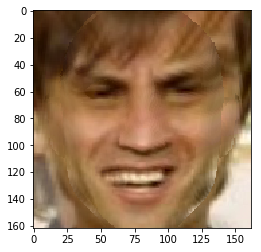

In [3]:
#face detected by haar , and frontalization

#cv2 face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#dlib landmark detector
predictor = dlib.shape_predictor('./dlib_models/shape_predictor_68_face_landmarks.dat')

# load the input image, resize it, and convert it to grayscale
image = cv2.imread('test.jpg')
image = imutils.resize(image, width=500)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#얼굴 검출
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

#얼굴에 사각형을 그려준다.
for (x,y,w,h) in faces:
    print(x,y,w,h)
#     cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

#     image=image[y:y+h,x:x+w]
    #dlib을 통해서 얼굴의 landmark 검출    
    rect=dlib.rectangle(int(x), int(y), int(x + w), int(y + h))   

    # determine the facial landmarks for the face region, then
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_numpy_array(shape)
    # output = visualize_facial_landmarks_circle(image, shape)

    model3D = frontalize.ThreeD_Model("./frontalization_models/model3Ddlib.mat", 'model_dlib')
#     plt.imshow(output)
#     plt.show()
    # perform camera calibration according to the first face detected
    proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, shape)
    # load mask to exclude eyes from symmetry
    eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
    # perform frontalization
    frontal_raw, frontal_sym = frontalize.frontalize(image, proj_matrix, model3D.ref_U, eyemask)
    frontal_sym = cv2.cvtColor(frontal_sym, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frontal_sym, cv2.COLOR_RGB2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        #얼굴에 사각형을 그려준다.
#         cv2.rectangle(frontal_sym,(x,y),(x+w,y+h),(255,0,0),2)
        frontal_sym=frontal_sym[y:y+h,x:x+w]
    plt.imshow(frontal_sym[:, :, ::-1])
    plt.show()